In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 12}

matplotlib.rc('font', **font)
plt.style.use('seaborn-muted')

SyntaxError: invalid syntax (_metadata_requests.py, line 1492)

In [ ]:
#-------Coverage------------
def coverage_attr(df, attribute, ground_truth):
    return df[attribute].nunique() / len(ground_truth)
#-------Density-------------
def density_attr(df, attribute):
    density_values = np.array(df[attribute].value_counts(normalize=True))
    value_avg = density_values.mean()
    return 1 - np.sqrt((density_values - value_avg) ** 2).mean()

#-------Diversity-----------
def diversity_attr_entropy(df, attribute):
    p = np.array(df[attribute].value_counts(normalize=True))
    return - (p*np.log(p)).sum()
def diversity_attr_gini(df, attribute):
    p = np.array(df[attribute].value_counts(normalize=True))
    return 1 - (p ** 2).sum()

#-------Class Overlap--------
### from DQToolkit
def class_overlap(X, y):
    #model = SVC(kernel='linear', C=1e5, random_state=1234)
    model = LogisticRegression(penalty="none", max_iter=5000)
    model.fit(X, y)
    decision_values = model.decision_function(X)
    threshold = decision_values.ptp() * 0.05
    points_inside_boundary = np.sum((decision_values >= -threshold) & (decision_values <= threshold))
    #print(f"Points inside boundary:{points_inside_boundary}\nClass Overlap:{points_inside_boundary/len(X)}")
    return points_inside_boundary/len(X)

#-------Label Purity--------
### from DQToolkit

def label_purity(X, y):
    n_clusters = y.nunique()
    kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
    kmeans = kmeans.fit(X)
    y_pred = kmeans.predict(X)
    contingency_matrix = metrics.cluster.contingency_matrix(y, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

#-------Class Balance--------
def average_class_balance(df, attribute):
    category_counts = df[attribute].value_counts()
    majority_class_count = category_counts.iloc[0]
    minority_counts = category_counts.iloc[1:]
    minority_count_average = np.mean(minority_counts)
    return minority_count_average/majority_class_count

def absolute_class_balance(df, attribute):
    category_counts = df[attribute].value_counts()
    majority_class_count = category_counts.iloc[0]
    minority_count_average = category_counts.iloc[-1]
    return minority_count_average/majority_class_count

#-------Group Fairness--------
def group_fairness(df, sensible_attribute, sensible_value, outcome):
    return df[df[sensible_attribute] == sensible_value][outcome].mean() / df[df[sensible_attribute] != sensible_value][outcome].mean()

#-------Historical Bias-------
def chi_square_test(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    chi2, p, _, _ = chi2_contingency([observed_frequencies, expected_frequencies])
    if p < 0.05:
        print("The difference is statistically significant.")
    else:
        print("The difference is not statistically significant.")

def bhattacharyya_coef(observed, expected):
    eps = 1e-5
    observed_frequencies = np.array([(100 * value) + eps for key, value in observed.items()])
    expected_frequencies = np.array([(100 * value) + eps for key, value in expected.items()])
    return np.sum([np.sqrt(observed_frequencies[i]*expected_frequencies[i]) for i in range(len(expected_frequencies))])

In [3]:
adult = pd.read_csv('dataset/adult.csv')
student = pd.read_csv('dataset/StudentsPerformance.csv')
german_credit = pd.read_csv('dataset/german_credit_data.csv')
heart = pd.read_csv('dataset/heart_attack.csv')

In [4]:
data = adult.copy()
data["income"] = data["income"].replace("<=50K",0).replace(">50K",1)
data = data.drop(["education","fnlwgt"], axis=1)
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)

enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == "object":
        data[i]=enc.fit_transform(data[i])

data['age'] = pd.qcut(data['age'],4,labels=False)
data['hours.per.week'] = pd.qcut(data['hours.per.week'],4,labels=False,duplicates='drop')
data = data.drop(["capital.gain", "capital.loss",'native.country'], axis=1)

X = data.drop('income', axis=1)
y = data['income']

sensible_attribute = 'sex'
privileged_value=1
y_class = 'income'

1.0
0.98681705107337
1.3844959142701925
0.7490914943012028
1.0
0.8462587528024323
0.9770955496171444
0.43702061925767466
1.0
0.9345773605693928
2.031857610044507
0.8095798357441002
1.0
0.8564816178613579
1.2709888797799445
0.6601085852736984
1.0
0.954251643226622
2.3535058831418296
0.894467384150256
1.0
0.8910318752154076
1.493332779585529
0.7321224447610938
1.0
0.7382905930407543
0.5536448302489407
0.2598329953466272
1.0
0.8307945087681582
0.6347398680222055
0.4427390034739822
1.0
0.7517207019986419
0.7729359161932923
0.4482184917012044
1.0
0.7408095574460244
0.5520112931915918
0.3656406289773486
0.31719255663430423
0.31719255663430423
0.14348453671570283
0.7591904425539756
2.7931201565097634


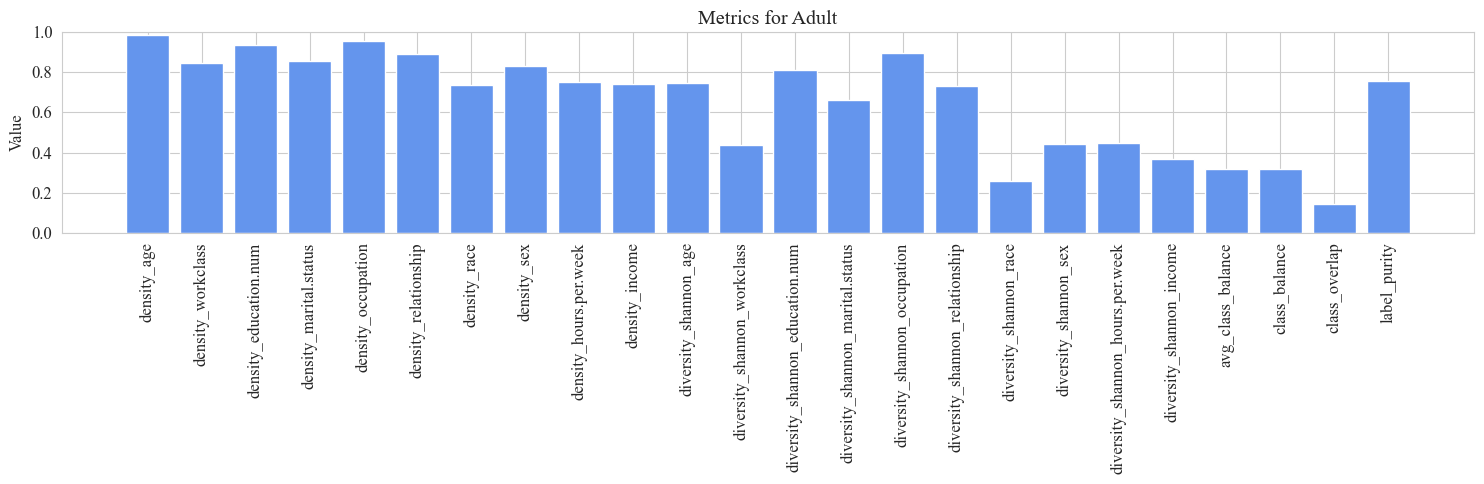

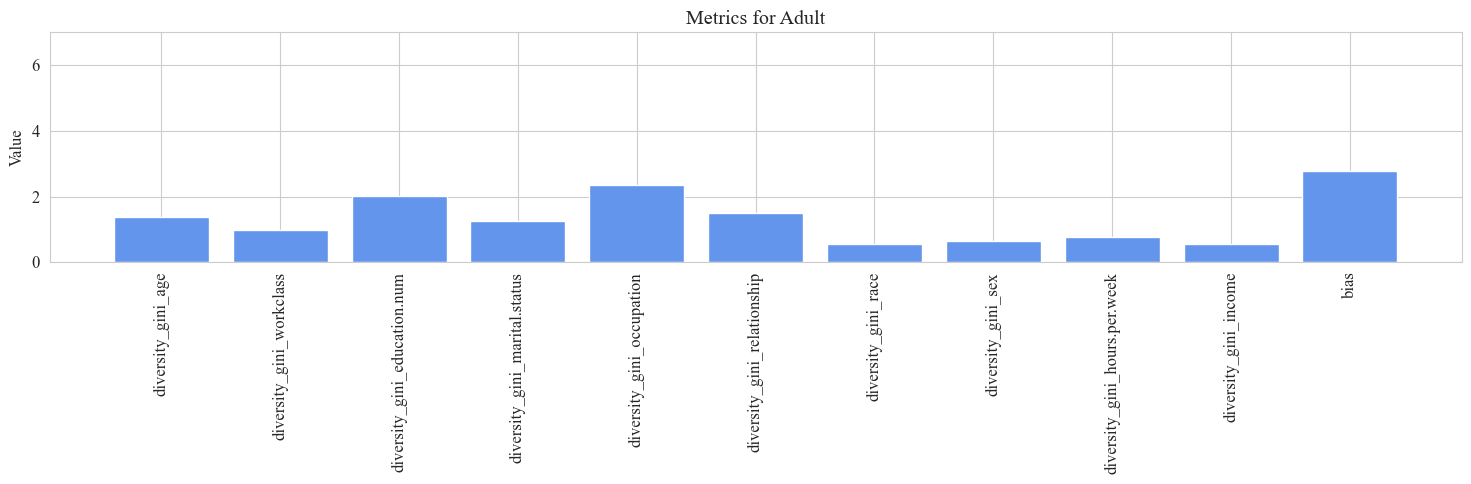

In [7]:
coverage = {}
density = {}
diversity_gini = {}
diversity_shannon = {}
other_metrics = {}

df = data
attributes = data.columns

for attribute in attributes:
    coverage[attribute] = coverage_attr(df, attribute, df[attribute].unique())
    print(coverage_attr(df, attribute, df[attribute].unique()))
    density[attribute] = density_attr(df, attribute)
    print(density_attr(df, attribute))
    diversity_gini[attribute] = diversity_attr_entropy(df, attribute)
    print(diversity_attr_entropy(df, attribute))
    diversity_shannon[attribute] = diversity_attr_gini(df, attribute)
    print(diversity_attr_gini(df, attribute))

other_metrics["avg_class_balance"] = average_class_balance(df, y_class)
print(average_class_balance(df, y_class))
other_metrics["class_balance"] = absolute_class_balance(df, y_class)
print(absolute_class_balance(df, y_class))
other_metrics["class_overlap"] = class_overlap(X, y)
print(class_overlap(X, y))
other_metrics["label_purity"] = label_purity(X, y)
print(label_purity(X, y))
other_metrics["bias"] = group_fairness(df, sensible_attribute, privileged_value, y_class)
print(group_fairness(df, sensible_attribute, privileged_value, y_class))

labels = []
#for attribute in attributes:
#    labels.append("coverage_"+attribute)
for attribute in attributes:
    labels.append("density_"+attribute)
#for attribute in attributes:
#    labels.append("diversity_gini_"+attribute)
for attribute in attributes:
    labels.append("diversity_shannon_"+attribute)
labels.append("avg_class_balance")
labels.append("class_balance")
labels.append("class_overlap")
labels.append("label_purity")
#labels.append("bias")

values = []
#for attribute in attributes:
#    values.append(coverage[attribute])
for attribute in attributes:
    values.append(density[attribute])
#for attribute in attributes:
#    values.append(diversity_gini[attribute])
for attribute in attributes:
    values.append(diversity_shannon[attribute])
values.append(other_metrics["avg_class_balance"])
values.append(other_metrics["class_balance"])
values.append(other_metrics["class_overlap"])
values.append(other_metrics["label_purity"])
#values.append(other_metrics["bias"])

x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="cornflowerblue")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Adult")
fig.tight_layout()
plt.ylim(0,1)
plt.savefig("plots/adult-1-assessment.svg", bbox_inches='tight')
plt.show()

labels = []
for attribute in attributes:
    labels.append("diversity_gini_"+attribute)
labels.append("bias")

values = []
for attribute in attributes:
    values.append(diversity_gini[attribute])
values.append(other_metrics["bias"])
x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="cornflowerblue")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Adult")
fig.tight_layout()
plt.ylim(0,7)
plt.savefig("plots/adult-2-assessment.svg", bbox_inches='tight')
plt.show()

In [8]:
data = student.copy()
data["math score"] = np.where(data["math score"] < 66, 0, 1)
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)

enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == "object":
        data[i]=enc.fit_transform(data[i])

X = data.drop('math score', axis=1)
y = data['math score']
y_class = 'math score'

1.0
0.982
0.6924990405193354
0.499352
0.9305019305019305
0.9305019305019305
1.0
0.9276
1.521499907426409
0.7659739999999999
0.5336990595611285
0.27899686520376177
1.0
0.9478888888888889
1.716751963038892
0.811778
0.6849557522123895
0.2610619469026549
1.0
0.855
0.6504870093850912
0.45794999999999997
0.5503875968992248
0.5503875968992248
1.0
0.858
0.6522587788817312
0.45967199999999997
0.557632398753894
0.557632398753894
1.0
0.983
0.6925690691470865
0.49942200000000003
0.9342359767891683
0.9342359767891683
1.0
0.9917469135802469
4.016248725008831
0.979604
0.4001657000828501
0.029411764705882353
1.0
0.9921696744813628
4.070530914623113
0.980566
0.36278195488721804
0.02857142857142857
0.267
0.791
1.0
0.982
0.6924990405193354
0.499352
1.0
0.9276
1.521499907426409
0.7659739999999999
1.0
0.9478888888888889
1.716751963038892
0.811778
1.0
0.855
0.6504870093850912
0.45794999999999997
1.0
0.858
0.6522587788817312
0.45967199999999997
1.0
0.983
0.6925690691470865
0.49942200000000003
1.0
0.991746913

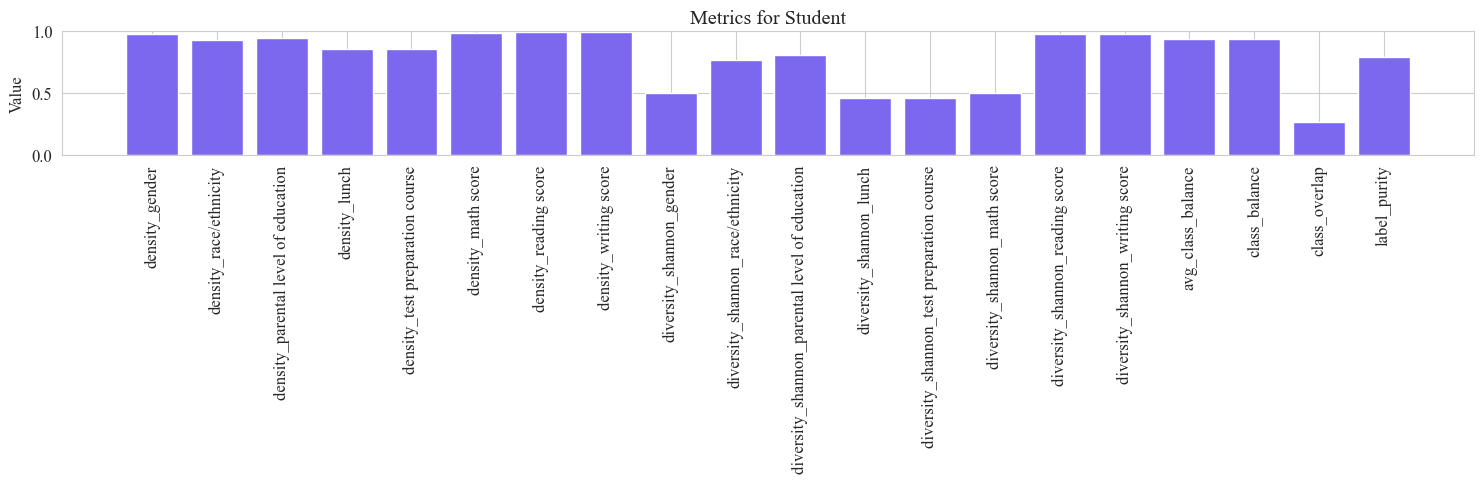

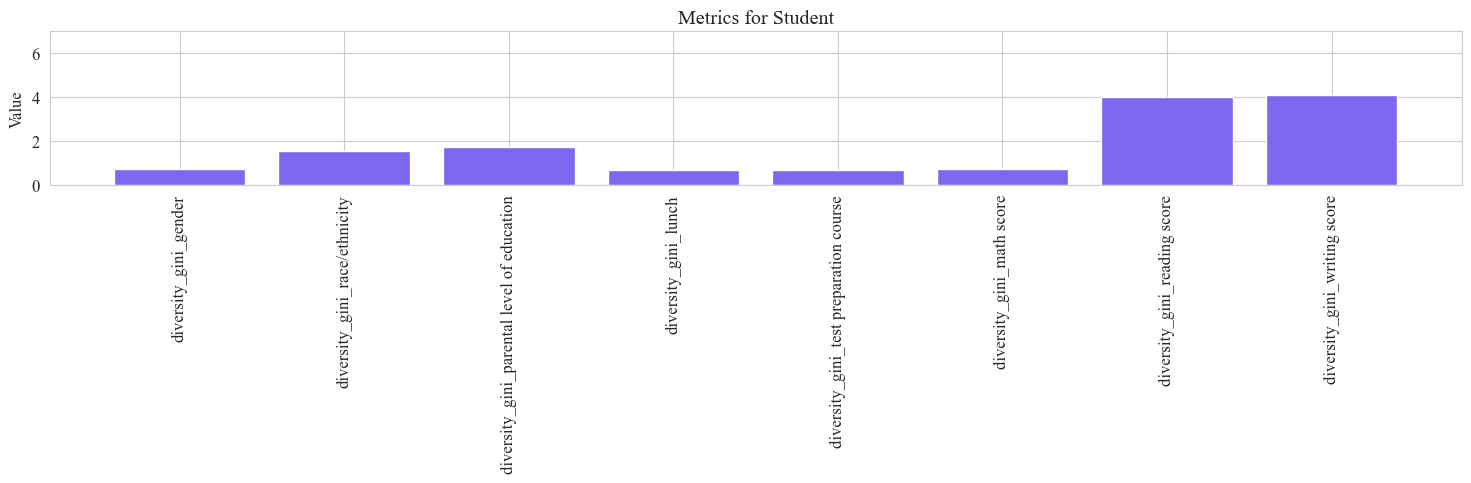

In [9]:
df = data
attributes = data.columns

for attribute in attributes:
    print(coverage_attr(df, attribute, df[attribute].unique()))
    print(density_attr(df, attribute))
    print(diversity_attr_entropy(df, attribute))
    print(diversity_attr_gini(df, attribute))
    print(average_class_balance(df, attribute))
    print(absolute_class_balance(df, attribute))

print(class_overlap(X, y))
print(label_purity(X, y))

coverage = {}
density = {}
diversity_gini = {}
diversity_shannon = {}
other_metrics = {}

df = data
attributes = data.columns

for attribute in attributes:
    coverage[attribute] = coverage_attr(df, attribute, df[attribute].unique())
    print(coverage_attr(df, attribute, df[attribute].unique()))
    density[attribute] = density_attr(df, attribute)
    print(density_attr(df, attribute))
    diversity_gini[attribute] = diversity_attr_entropy(df, attribute)
    print(diversity_attr_entropy(df, attribute))
    diversity_shannon[attribute] = diversity_attr_gini(df, attribute)
    print(diversity_attr_gini(df, attribute))

other_metrics["avg_class_balance"] = average_class_balance(df, y_class)
print(average_class_balance(df, y_class))
other_metrics["class_balance"] = absolute_class_balance(df, y_class)
print(absolute_class_balance(df, y_class))
other_metrics["class_overlap"] = class_overlap(X, y)
print(class_overlap(X, y))
other_metrics["label_purity"] = label_purity(X, y)
print(label_purity(X, y))

labels = []
#for attribute in attributes:
#    labels.append("coverage_"+attribute)
for attribute in attributes:
    labels.append("density_"+attribute)
#for attribute in attributes:
#    labels.append("diversity_gini_"+attribute)
for attribute in attributes:
    labels.append("diversity_shannon_"+attribute)
labels.append("avg_class_balance")
labels.append("class_balance")
labels.append("class_overlap")
labels.append("label_purity")
#labels.append("bias")

values = []
#for attribute in attributes:
#    values.append(coverage[attribute])
for attribute in attributes:
    values.append(density[attribute])
#for attribute in attributes:
#    values.append(diversity_gini[attribute])
for attribute in attributes:
    values.append(diversity_shannon[attribute])
values.append(other_metrics["avg_class_balance"])
values.append(other_metrics["class_balance"])
values.append(other_metrics["class_overlap"])
values.append(other_metrics["label_purity"])
#values.append(other_metrics["bias"])

x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="mediumslateblue")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Student")
fig.tight_layout()
plt.ylim(0,1)
plt.savefig("plots/student-1-assessment.svg", bbox_inches='tight')
plt.show()

labels = []
for attribute in attributes:
    labels.append("diversity_gini_"+attribute)

values = []
for attribute in attributes:
    values.append(diversity_gini[attribute])
x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="mediumslateblue")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Student")
fig.tight_layout()
plt.ylim(0,7)
plt.savefig("plots/student-2-assessment.svg", bbox_inches='tight')
plt.show()

In [10]:
data = german_credit.copy()
data['Risk'] = data['Risk'].replace({'good': 1, 'bad': 0})

data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)

enc = LabelEncoder()
for i in data.columns:
    if data[i].dtype == "object":
        data[i]=enc.fit_transform(data[i])

X = data.drop(['Risk', 'id'], axis=1)
y = data['Risk']

y_class='Risk'
sensible_attribute = 'Sex'#Age
privileged_value=1

1.0
1.0
6.907755278982134
0.999
1.0
0.9871456034175863
3.652656573569478
0.969296
1.0
0.81
0.6191006644255871
0.42780000000000007
1.0
0.81
0.9796979689686434
0.540712
1.0
0.7468888888888889
0.7895027944518331
0.44792600000000005
1.0
0.784
0.8493568504334238
0.4273960000000001
1.0
0.8371111111111111
0.9316482503740179
0.577094
1.0
0.9998422311583618
6.795621783734841
0.998832
1.0
0.9659228650137741
2.6094861584205655
0.895904
1.0
0.89425
1.6157559122328262
0.761608
1.0
0.8
0.6108643020548935
0.42000000000000004
0.42857142857142855
0.42857142857142855
0.083
0.7
1.1153652029706538


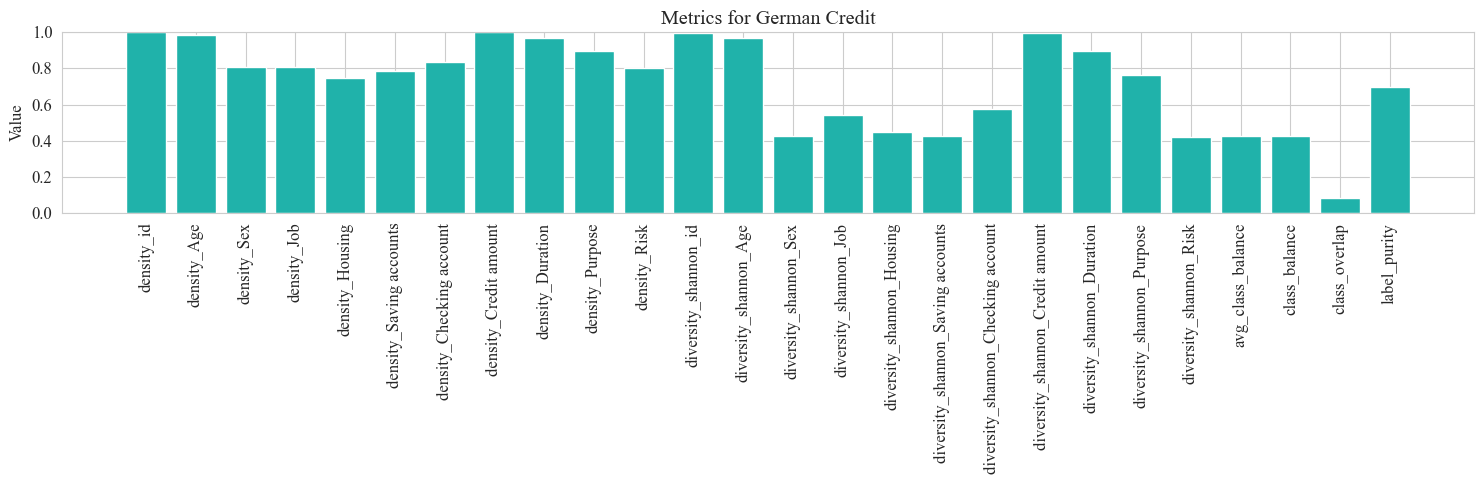

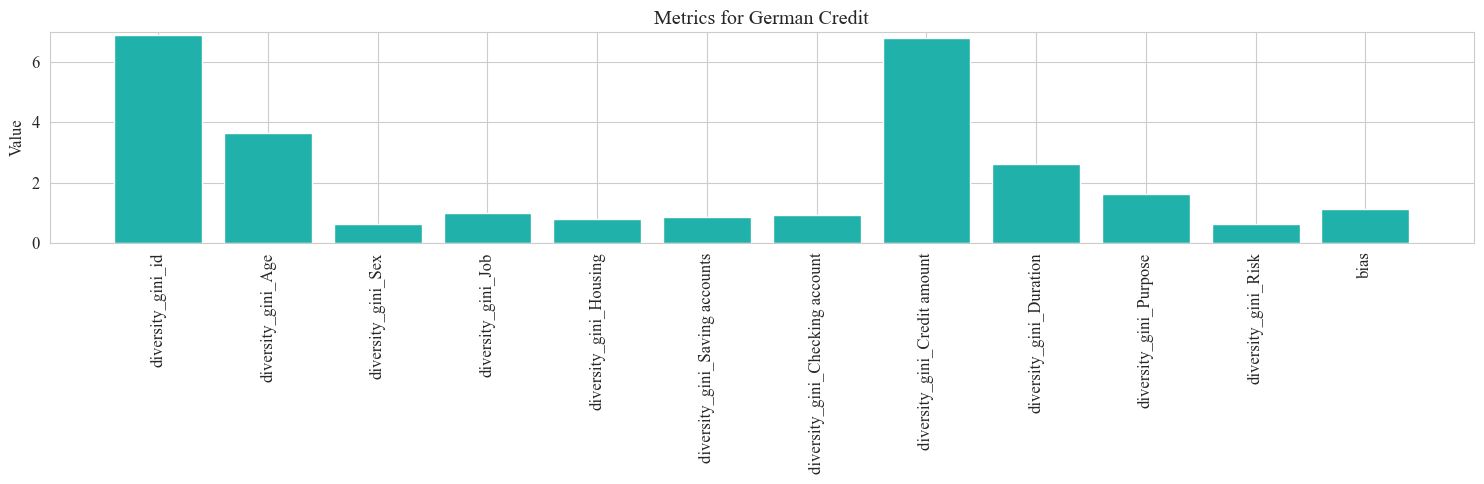

In [11]:
coverage = {}
density = {}
diversity_gini = {}
diversity_shannon = {}
other_metrics = {}

df = data
attributes = data.columns

for attribute in attributes:
    coverage[attribute] = coverage_attr(df, attribute, df[attribute].unique())
    print(coverage_attr(df, attribute, df[attribute].unique()))
    density[attribute] = density_attr(df, attribute)
    print(density_attr(df, attribute))
    diversity_gini[attribute] = diversity_attr_entropy(df, attribute)
    print(diversity_attr_entropy(df, attribute))
    diversity_shannon[attribute] = diversity_attr_gini(df, attribute)
    print(diversity_attr_gini(df, attribute))

other_metrics["avg_class_balance"] = average_class_balance(df, y_class)
print(average_class_balance(df, y_class))
other_metrics["class_balance"] = absolute_class_balance(df, y_class)
print(absolute_class_balance(df, y_class))
other_metrics["class_overlap"] = class_overlap(X, y)
print(class_overlap(X, y))
other_metrics["label_purity"] = label_purity(X, y)
print(label_purity(X, y))
other_metrics["bias"] = group_fairness(df, sensible_attribute, privileged_value, y_class)
print(group_fairness(df, sensible_attribute, privileged_value, y_class))

labels = []
#for attribute in attributes:
#    labels.append("coverage_"+attribute)
for attribute in attributes:
    labels.append("density_"+attribute)
#for attribute in attributes:
#    labels.append("diversity_gini_"+attribute)
for attribute in attributes:
    labels.append("diversity_shannon_"+attribute)
labels.append("avg_class_balance")
labels.append("class_balance")
labels.append("class_overlap")
labels.append("label_purity")
#labels.append("bias")

values = []
#for attribute in attributes:
#    values.append(coverage[attribute])
for attribute in attributes:
    values.append(density[attribute])
#for attribute in attributes:
#    values.append(diversity_gini[attribute])
for attribute in attributes:
    values.append(diversity_shannon[attribute])
values.append(other_metrics["avg_class_balance"])
values.append(other_metrics["class_balance"])
values.append(other_metrics["class_overlap"])
values.append(other_metrics["label_purity"])
#values.append(other_metrics["bias"])

x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="lightseagreen")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for German Credit")
fig.tight_layout()
plt.ylim(0,1)
plt.savefig("plots/german-1-assessment.svg", bbox_inches='tight')
plt.show()

labels = []
for attribute in attributes:
    labels.append("diversity_gini_"+attribute)
labels.append("bias")

values = []
for attribute in attributes:
    values.append(diversity_gini[attribute])
values.append(other_metrics["bias"])
x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="lightseagreen")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for German Credit")
fig.tight_layout()
plt.ylim(0,7)
plt.savefig("plots/german-2-assessment.svg", bbox_inches='tight')
plt.show()

In [73]:
data = heart.copy()
data.replace('?',np.NaN,inplace=True)
data.fillna(method='ffill',inplace=True)

X = data.drop(['output'], axis=1)
y = data['output']
y_class = 'output'
df = data
attributes = data.columns

1.0
0.9881180265557787
3.5194925978551734
0.9665936890718775
0.3736842105263158
0.05263157894736842
1.0
0.8168316831683168
0.6244581633085649
0.4328987354180962
0.463768115942029
0.463768115942029
1.0
0.8704620462046204
1.205685592017972
0.6618305394895926
0.372960372960373
0.16083916083916083
1.0
0.9814378772321214
3.255998278305943
0.9410406387173371
0.14977477477477477
0.02702702702702703
1.0
0.9973253384895276
4.882240890490256
0.9913189338735854
0.32781456953642385
0.16666666666666666
1.0
0.6485148514851485
0.42012427432309296
0.25291638074698564
0.1744186046511628
0.1744186046511628
1.0
0.7865786578657866
0.7541004396031387
0.5128037556230871
0.4967105263157895
0.02631578947368421
1.0
0.9935587569142134
4.275784138947015
0.9835854872615974
0.29494949494949496
0.09090909090909091
1.0
0.8267326732673267
0.6318405813920605
0.4399568669738261
0.4852941176470588
0.4852941176470588
1.0
0.9772813531353135
2.8614303117696864
0.8728338180352688
0.05283605283605284
0.010101010101010102
1.0

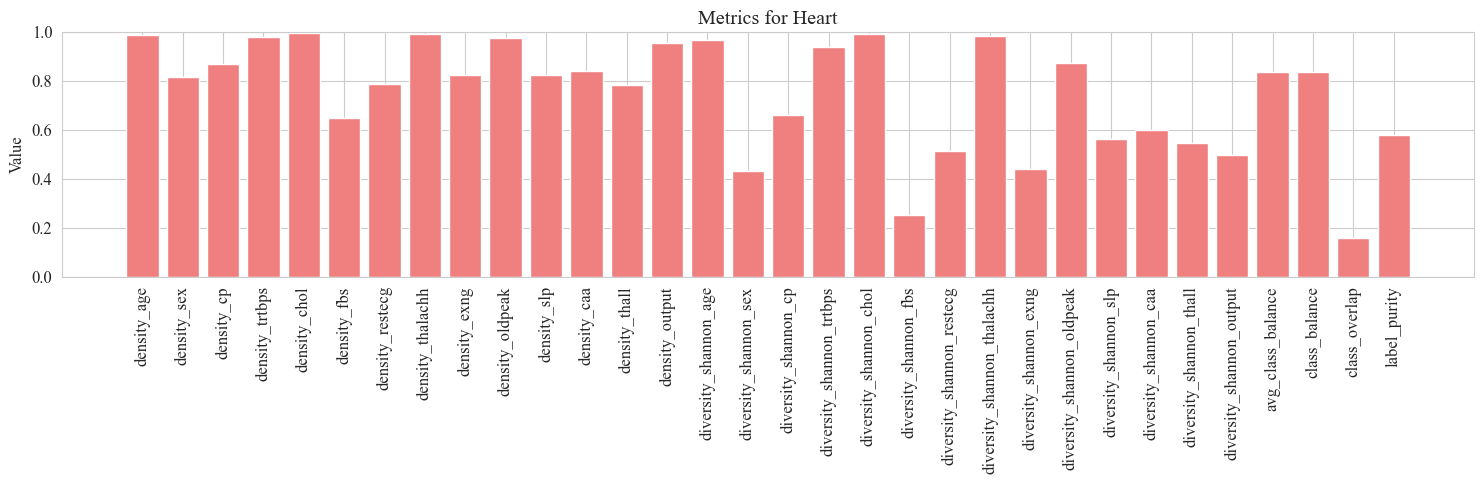

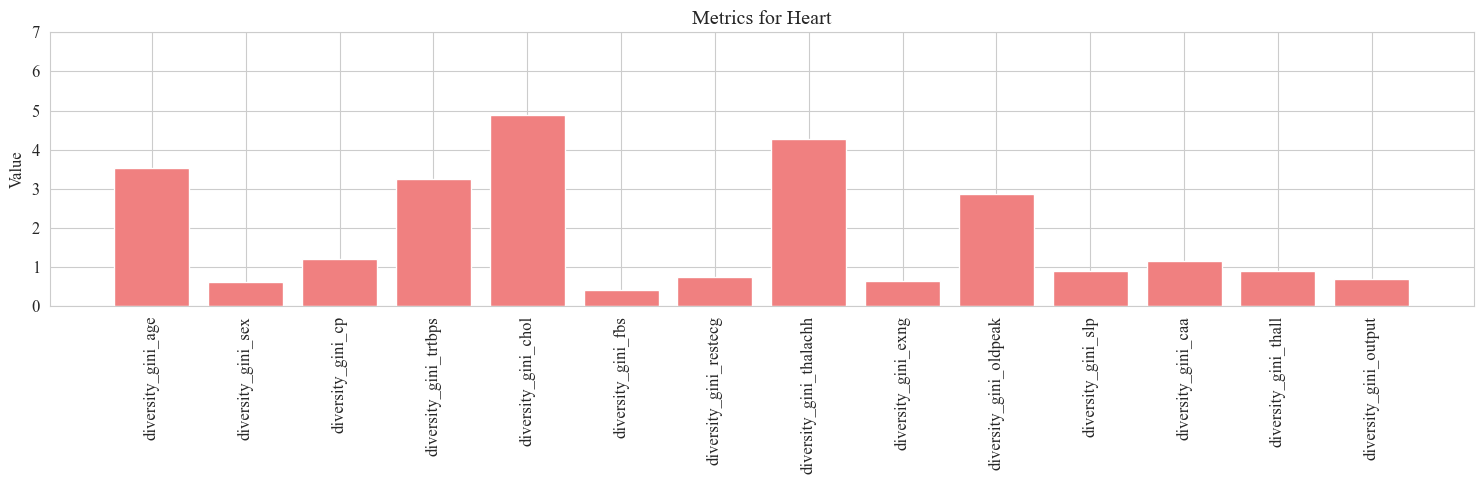

In [74]:
for attribute in attributes:
    print(coverage_attr(df, attribute, df[attribute].unique()))
    print(density_attr(df, attribute))
    print(diversity_attr_entropy(df, attribute))
    print(diversity_attr_gini(df, attribute))
    print(average_class_balance(df, attribute))
    print(absolute_class_balance(df, attribute))

print(class_overlap(X, y))
print(label_purity(X, y))

coverage = {}
density = {}
diversity_gini = {}
diversity_shannon = {}
other_metrics = {}

df = data
attributes = data.columns

for attribute in attributes:
    coverage[attribute] = coverage_attr(df, attribute, df[attribute].unique())
    print(coverage_attr(df, attribute, df[attribute].unique()))
    density[attribute] = density_attr(df, attribute)
    print(density_attr(df, attribute))
    diversity_gini[attribute] = diversity_attr_entropy(df, attribute)
    print(diversity_attr_entropy(df, attribute))
    diversity_shannon[attribute] = diversity_attr_gini(df, attribute)
    print(diversity_attr_gini(df, attribute))

other_metrics["avg_class_balance"] = average_class_balance(df, y_class)
print(average_class_balance(df, y_class))
other_metrics["class_balance"] = absolute_class_balance(df, y_class)
print(absolute_class_balance(df, y_class))
other_metrics["class_overlap"] = class_overlap(X, y)
print(class_overlap(X, y))
other_metrics["label_purity"] = label_purity(X, y)
print(label_purity(X, y))

labels = []
#for attribute in attributes:
#    labels.append("coverage_"+attribute)
for attribute in attributes:
    labels.append("density_"+attribute)
#for attribute in attributes:
#    labels.append("diversity_gini_"+attribute)
for attribute in attributes:
    labels.append("diversity_shannon_"+attribute)
labels.append("avg_class_balance")
labels.append("class_balance")
labels.append("class_overlap")
labels.append("label_purity")
#labels.append("bias")

values = []
#for attribute in attributes:
#    values.append(coverage[attribute])
for attribute in attributes:
    values.append(density[attribute])
#for attribute in attributes:
#    values.append(diversity_gini[attribute])
for attribute in attributes:
    values.append(diversity_shannon[attribute])
values.append(other_metrics["avg_class_balance"])
values.append(other_metrics["class_balance"])
values.append(other_metrics["class_overlap"])
values.append(other_metrics["label_purity"])
#values.append(other_metrics["bias"])

x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="lightcoral")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Heart")
fig.tight_layout()
plt.savefig("plots/heart-1-assessment.svg", bbox_inches='tight')
plt.ylim(0,1)
plt.show()

labels = []
for attribute in attributes:
    labels.append("diversity_gini_"+attribute)

values = []
for attribute in attributes:
    values.append(diversity_gini[attribute])
x = np.arange(len(labels))
fig = plt.figure(figsize=(15, 5))
plt.bar(x, values, color="lightcoral")
plt.xticks(x, labels, rotation=90)
plt.ylabel("Value")
plt.title("Metrics for Heart")
fig.tight_layout()
plt.ylim(0,7)
plt.savefig("plots/heart-2-assessment.svg", bbox_inches='tight')
plt.show()